# Automatic Cancer Diagnosis

### Assignments

<ol>
    <li> Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)</li>
    <li> Instead of using all the words in the dataset, use only the top 1000 words based of idf values</li>
    <li>Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams</li>
    <li> Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0</li>
</ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from tqdm import tqdm
from tqdm import tqdm_pandas
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

### 1. Reading Data

In [2]:
csv_path = '/home/monodeepdas112/Datasets/CancerDetection/training_variants'
data = pd.read_csv(csv_path)
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

### 2 Reading Text Data

In [3]:
# note the seprator in this file
text_path = '/home/monodeepdas112/Datasets/CancerDetection/training_text'
data_text =pd.read_csv(text_path, sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3. Preprocessing of text

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in tqdm(data_text.iterrows()):
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

1126it [01:09, 17.07it/s]

there is no text description for id: 1109


1288it [01:19, 15.78it/s]

there is no text description for id: 1277


1428it [01:27, 16.92it/s]

there is no text description for id: 1407


1654it [01:41, 18.00it/s]

there is no text description for id: 1639


2767it [02:50, 15.06it/s]

there is no text description for id: 2755


3321it [03:24, 17.41it/s]

Time took for preprocessing the text : 206.059639 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 4. Test, Train and Cross Validation Split

#### 4.1. Splitting data into train, test and cross validation (64:20:16)

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
# cls_text is a data frame
# for every row in dataframe consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [12]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### 5. Featurizations

In [14]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [15]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3, ngram_range=[1,2])
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [16]:
#response-coding of the Gene and variation feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [17]:
# building a CountVectorizer for gene
count_gene_vect = CountVectorizer()
count_gene_vect.fit(train_df['Gene'])

train_gene_feature_onehot = count_gene_vect.transform(train_df['Gene'])
test_gene_feature_onehot = count_gene_vect.transform(test_df['Gene'])
cv_gene_feature_onehot = count_gene_vect.transform(cv_df['Gene'])


# building a CountVectorizer for variation
count_var_vect = CountVectorizer()
count_var_vect.fit(train_df['Variation'])

train_variation_feature_onehot = count_var_vect.transform(train_df['Variation'])
test_variation_feature_onehot = count_var_vect.transform(test_df['Variation'])
cv_variation_feature_onehot = count_var_vect.transform(cv_df['Variation'])


# building a CountVectorizer for text
count_text_vect = CountVectorizer(min_df=3, ngram_range=[1,2])
count_text_vect.fit(train_df['TEXT'])

train_text_bow = count_text_vect.transform(train_df['TEXT'])
test_text_bow = count_text_vect.transform(test_df['TEXT'])
cv_text_bow = count_text_vect.transform(cv_df['TEXT'])


# building a CountVectorizer for text
tfidf_text_vect = TfidfVectorizer(min_df=3, ngram_range=[1,2])
tfidf_text_vect.fit(train_df['TEXT'])

train_text_tfidf = tfidf_text_vect.transform(train_df['TEXT'])
test_text_tfidf = tfidf_text_vect.transform(test_df['TEXT'])
cv_text_tfidf = tfidf_text_vect.transform(cv_df['TEXT'])

#### Stacking the three types of features

In [18]:
# stacking onehot gene with onehot variation with bow text
train_bow_onehot_features = hstack((train_gene_feature_onehot, train_variation_feature_onehot, train_text_bow)).tocsr()
test_bow_onehot_features = hstack((test_gene_feature_onehot, test_variation_feature_onehot, test_text_bow)).tocsr()
cv_bow_onehot_features = hstack((cv_gene_feature_onehot, cv_variation_feature_onehot, cv_text_bow)).tocsr()

# stacking onehot gene with onehot variation with tfidf text
train_tfidf_onehot_features = hstack((train_gene_feature_onehot, train_variation_feature_onehot, train_text_tfidf)).tocsr()
test_tfidf_onehot_features = hstack((test_gene_feature_onehot, test_variation_feature_onehot, test_text_tfidf)).tocsr()
cv_tfidf_onehot_features = hstack((cv_gene_feature_onehot, cv_variation_feature_onehot, cv_text_tfidf)).tocsr()

# stacking response gene with response variation with bow text
train_bow_response_features = hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding, train_text_bow)).tocsr()
test_bow_response_features = hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding, test_text_bow)).tocsr()
cv_bow_response_features = hstack((cv_gene_feature_responseCoding, cv_variation_feature_responseCoding, cv_text_bow)).tocsr()

# stacking response gene with response variation with tfidf text
train_tfidf_response_features = hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding, train_text_tfidf)).tocsr()
test_tfidf_response_features = hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding, test_text_tfidf)).tocsr()
cv_tfidf_response_features = hstack((cv_gene_feature_responseCoding, cv_variation_feature_responseCoding, cv_text_tfidf)).tocsr()

In [19]:
train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

### 6. Fitting models

### 6.1 Baseline model - Naive Bayes

#### 6.1.1 Feature - Onehot with BOW

for alpha = 1e-05
Log Loss : 1.5036069503758847
for alpha = 0.0001
Log Loss : 1.4766501833371857
for alpha = 0.001
Log Loss : 1.483410225538635
for alpha = 0.1
Log Loss : 1.4569644690739754
for alpha = 1
Log Loss : 1.4258124993942682
for alpha = 10
Log Loss : 1.4290711598552386
for alpha = 100
Log Loss : 1.6946426260067773
for alpha = 1000
Log Loss : 1.7859474881161315


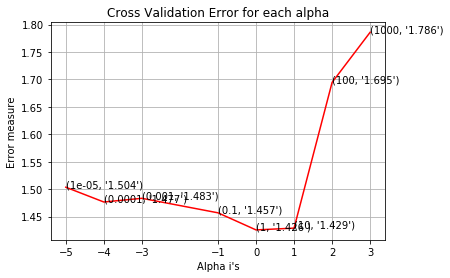

For values of best alpha =  1 The train log loss is: 0.9340638181654991
For values of best alpha =  1 The cross validation log loss is: 1.4258124993942682
For values of best alpha =  1 The test log loss is: 1.4401692121587184


In [20]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_bow_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    
    sig_clf.fit(train_bow_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_bow_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
sig_clf.fit(train_bow_onehot_features, train_y)


predict_y = sig_clf.predict_proba(train_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.1.2 Feature - Onehot with TFIDF

for alpha = 1e-05
Log Loss : 1.4876902150466456
for alpha = 0.0001
Log Loss : 1.4594526849319147
for alpha = 0.001
Log Loss : 1.4355370537110375
for alpha = 0.1
Log Loss : 1.3340974086798894
for alpha = 1
Log Loss : 1.296071274317102
for alpha = 10
Log Loss : 1.1926865603016439
for alpha = 100
Log Loss : 1.2478168339946871
for alpha = 1000
Log Loss : 1.2660961157000146


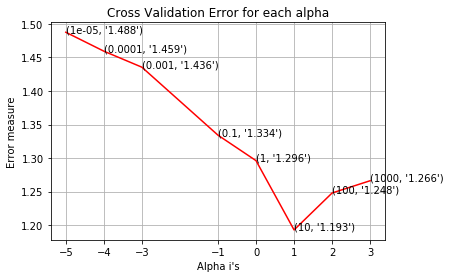

For values of best alpha =  10 The train log loss is: 1.0190340287801998
For values of best alpha =  10 The cross validation log loss is: 1.1926865603016439
For values of best alpha =  10 The test log loss is: 1.2611130595676376


In [21]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    
    sig_clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
sig_clf.fit(train_tfidf_onehot_features, train_y)


predict_y = sig_clf.predict_proba(train_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss : 1.2660961157000146
Number of missclassified point : 0.40977443609022557
-------------------- Confusion matrix --------------------


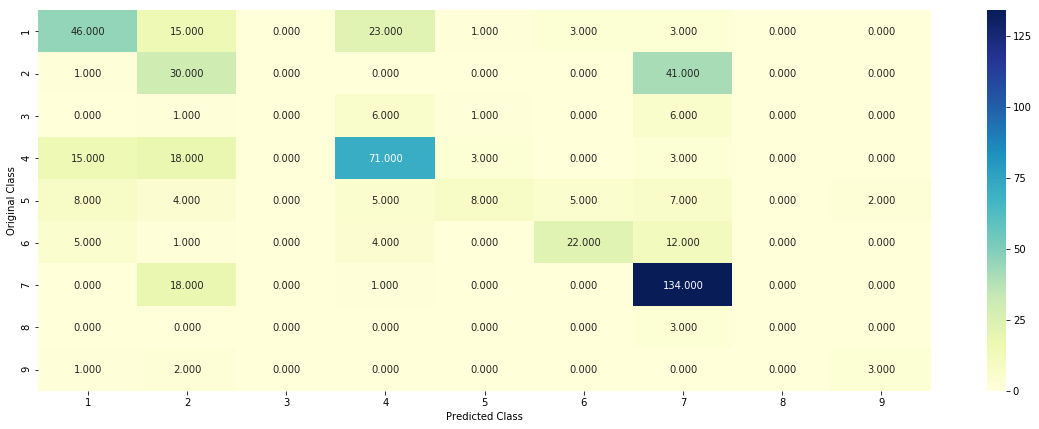

-------------------- Precision matrix (Columm Sum=1) --------------------


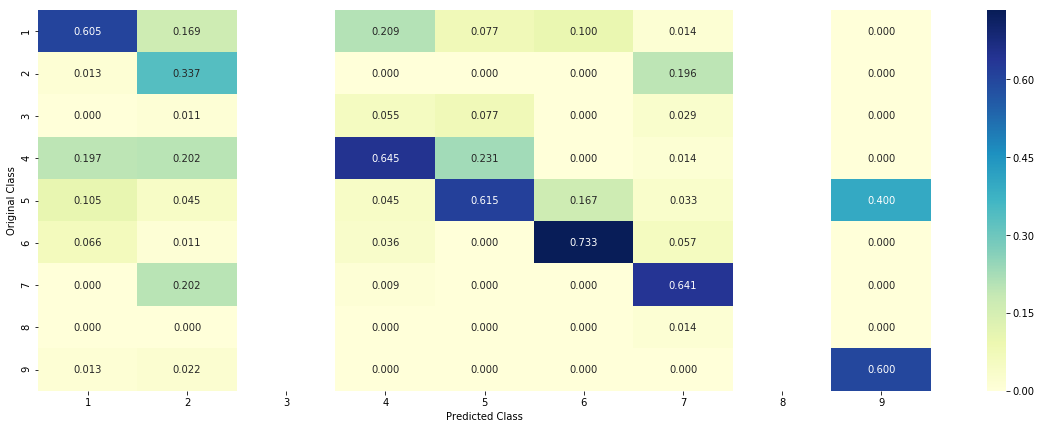

-------------------- Recall matrix (Row sum=1) --------------------


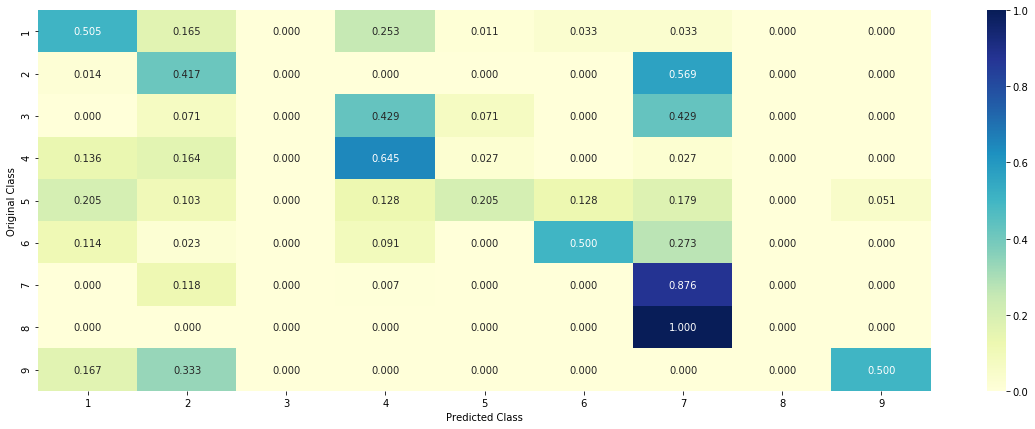

In [22]:
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_tfidf_onehot_features)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_tfidf_onehot_features.toarray()))

<h4>6.1.2.1. Feature Importance, Correctly classified point</h4>

In [23]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_tfidf_onehot_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_onehot_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[3.600e-02 1.340e-02 1.180e-02 2.290e-02 5.170e-02 8.588e-01 3.900e-03
  1.100e-03 3.000e-04]]
Actual Class : 6
--------------------------------------------------
2 Text feature [brca1] present in test data point [True]
3 Text feature [variants] present in test data point [True]
4 Text feature [deleterious] present in test data point [True]
6 Text feature [brca2] present in test data point [True]
7 Text feature [vus] present in test data point [True]
8 Text feature [mutations] present in test data point [True]
9 Text feature [brca] present in test data point [True]
11 Text feature [odds] present in test data point [True]
14 Text feature [cancer] present in test data point [True]
15 Text feature [mutation] present in test data point [True]
16 Text feature [brct] present in test data point [True]
17 Text feature [vuss] present in test data point [True]
18 Text feature [neutral] present in test data point [True]
20 Text feature [variant]

<h4>6.1.2.2. Feature Importance, Incorrectly classified point</h4>

In [24]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_tfidf_onehot_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_onehot_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0242 0.1315 0.0212 0.0271 0.0481 0.0556 0.689  0.0025 0.0008]]
Actual Class : 6
--------------------------------------------------
1 Text feature [mutations] present in test data point [True]
4 Text feature [cells] present in test data point [True]
12 Text feature [cell] present in test data point [True]
14 Text feature [fig] present in test data point [True]
15 Text feature [ras] present in test data point [True]
16 Text feature [kinase] present in test data point [True]
17 Text feature [patients] present in test data point [True]
18 Text feature [mutation] present in test data point [True]
29 Text feature [raf] present in test data point [True]
30 Text feature [braf] present in test data point [True]
31 Text feature [cancer] present in test data point [True]
32 Text feature [mutant] present in test data point [True]
37 Text feature [tumor] present in test data point [True]
41 Text feature [tumors] present in test data point [True

#### 6.1.3 Feature - Response with BOW

for alpha = 1e-05
Log Loss : 1.498165222396136
for alpha = 0.0001
Log Loss : 1.473400719604246
for alpha = 0.001
Log Loss : 1.481898149175489
for alpha = 0.1
Log Loss : 1.462426475828153
for alpha = 1
Log Loss : 1.4261230019834117
for alpha = 10
Log Loss : 1.4287933391139205
for alpha = 100
Log Loss : 1.6941628604706906
for alpha = 1000
Log Loss : 1.7859385366733487


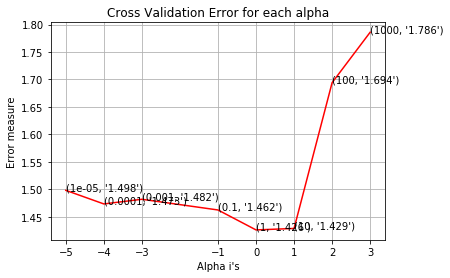

For values of best alpha =  1 The train log loss is: 0.9347008760644467
For values of best alpha =  1 The cross validation log loss is: 1.4261230019834117
For values of best alpha =  1 The test log loss is: 1.4398067239842225


In [25]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_bow_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    
    sig_clf.fit(train_bow_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_bow_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
sig_clf.fit(train_bow_response_features, train_y)


predict_y = sig_clf.predict_proba(train_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.1.1 Feature - Response with TFIDF

for alpha = 1e-05
Log Loss : 1.390118730396215
for alpha = 0.0001
Log Loss : 1.3864561610373833
for alpha = 0.001
Log Loss : 1.3968535032533256
for alpha = 0.1
Log Loss : 1.3310559948175205
for alpha = 1
Log Loss : 1.3657216440036812
for alpha = 10
Log Loss : 1.3452272634602374
for alpha = 100
Log Loss : 1.2867785286181823
for alpha = 1000
Log Loss : 1.2518547876654251


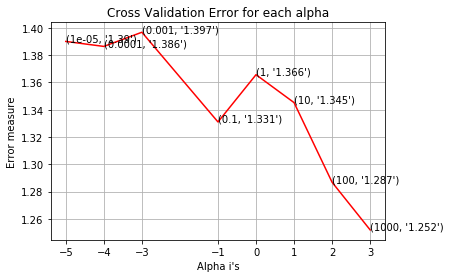

For values of best alpha =  1000 The train log loss is: 1.1717410615702781
For values of best alpha =  1000 The cross validation log loss is: 1.2518547876654251
For values of best alpha =  1000 The test log loss is: 1.2884034784492435


In [26]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_tfidf_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
    
    sig_clf.fit(train_tfidf_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv='prefit')
sig_clf.fit(train_tfidf_response_features, train_y)


predict_y = sig_clf.predict_proba(train_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 6.2 K-Nearest Neighbours

Since dataset size is small and we do not have any response time limit requirements I am trying out OneHot Coding features with KNN as well and comparing all the possibilities

#### 6.2.1 Feature - Onehot with BOW

for alpha = 5
Log Loss : 1.2832966661385778
for alpha = 11
Log Loss : 1.2775640381817417
for alpha = 15
Log Loss : 1.2845009820895326
for alpha = 21
Log Loss : 1.312643847727437
for alpha = 31
Log Loss : 1.3690153462534216
for alpha = 41
Log Loss : 1.3660797871428914
for alpha = 51
Log Loss : 1.39110166526791
for alpha = 99
Log Loss : 1.4023865732226706


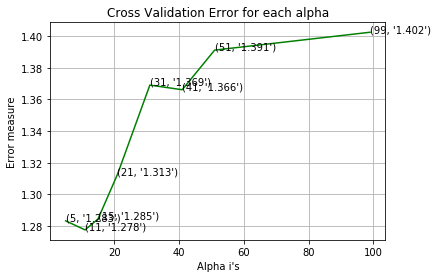

For values of best alpha =  11 The train log loss is: 0.9582566724999213
For values of best alpha =  11 The cross validation log loss is: 1.2775640381817417
For values of best alpha =  11 The test log loss is: 1.3043426701936207


In [27]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_bow_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_bow_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.2.2 Feature - Onehot with TFIDF

for alpha = 5
Log Loss : 1.1587267805047112
for alpha = 11
Log Loss : 1.098273452178832
for alpha = 15
Log Loss : 1.0985360871430163
for alpha = 21
Log Loss : 1.135128008372018
for alpha = 31
Log Loss : 1.1669394047354755
for alpha = 41
Log Loss : 1.1936079675864641
for alpha = 51
Log Loss : 1.2023264138191208
for alpha = 99
Log Loss : 1.2852019098760887


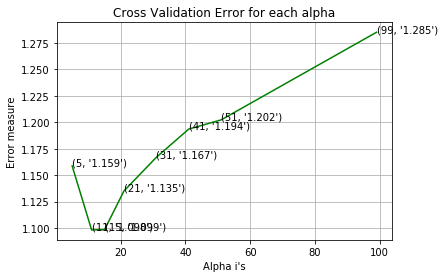

For values of best alpha =  11 The train log loss is: 0.87380967820423
For values of best alpha =  11 The cross validation log loss is: 1.098273452178832
For values of best alpha =  11 The test log loss is: 1.1751977255728103


In [28]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.2.3 Feature - Response with BOW

for alpha = 5
Log Loss : 1.2803847624329263
for alpha = 11
Log Loss : 1.279103096793844
for alpha = 15
Log Loss : 1.2832353334475048
for alpha = 21
Log Loss : 1.313298977746649
for alpha = 31
Log Loss : 1.3672925694785742
for alpha = 41
Log Loss : 1.365165762930205
for alpha = 51
Log Loss : 1.3904637975835143
for alpha = 99
Log Loss : 1.4020254832484345


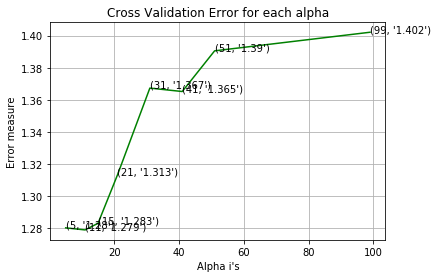

For values of best alpha =  11 The train log loss is: 0.9281210162923642
For values of best alpha =  11 The cross validation log loss is: 1.279103096793844
For values of best alpha =  11 The test log loss is: 1.3054637022002626


In [29]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_bow_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_bow_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_response_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.2.4 Feature - Response with TFIDF

for alpha = 5
Log Loss : 1.198801127068247
for alpha = 11
Log Loss : 1.1501063993531673
for alpha = 15
Log Loss : 1.1440347820998134
for alpha = 21
Log Loss : 1.1711962369919213
for alpha = 31
Log Loss : 1.197417170667002
for alpha = 41
Log Loss : 1.2134419601176856
for alpha = 51
Log Loss : 1.2104115025133875
for alpha = 99
Log Loss : 1.2138858527231913


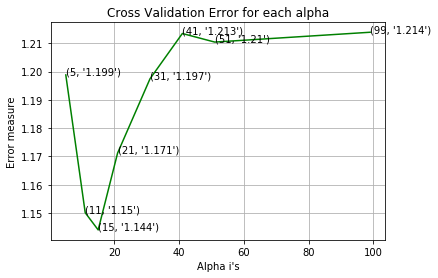

For values of best alpha =  15 The train log loss is: 0.9439439180685022
For values of best alpha =  15 The cross validation log loss is: 1.1440347820998134
For values of best alpha =  15 The test log loss is: 1.2206572717664992


In [30]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_tfidf_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>6.2.4.1.Sample Query point -1</h4>

In [31]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_tfidf_response_features[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_tfidf_response_features[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 6
The  15  nearest neighbours of the test points belongs to classes [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Fequency of nearest points : Counter({6: 15})


<h4>6.2.4.2.Sample Query point -2</h4>

In [32]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_tfidf_response_features[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_tfidf_response_features[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [6 6 7 7 7 7 7 7 7 7 4 2 2 6 7]
Fequency of nearest points : Counter({7: 9, 6: 3, 2: 2, 4: 1})


### 6.3 Logistic Regression

In [33]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [34]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

Trying out with <b>Class Balancing</b> only as it was seen earlier that class balancing gave better results

#### 6.3.1 Feature - OneHot with BOW

for alpha = 1e-06
Log Loss : 1.8302731648966806
for alpha = 1e-05
Log Loss : 1.8302731648966806
for alpha = 0.0001
Log Loss : 1.9841423580579787
for alpha = 0.001
Log Loss : 2.141058940033097
for alpha = 0.01
Log Loss : 1.8872864732217824
for alpha = 0.1
Log Loss : 1.6921852801078243
for alpha = 1
Log Loss : 1.6597797189325825
for alpha = 10
Log Loss : 1.3341653925274348
for alpha = 100
Log Loss : 1.2825385365922575


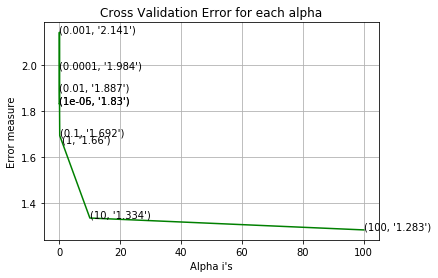

For values of best alpha =  100 The train log loss is: 1.0148728745422024
For values of best alpha =  100 The cross validation log loss is: 1.2825385365922575
For values of best alpha =  100 The test log loss is: 1.3237591529785127


In [35]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_bow_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='log', random_state=42)
clf.fit(train_bow_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.3.2 Feature - OneHot with TFIDF

for alpha = 1e-06
Log Loss : 2.4822222729504184
for alpha = 1e-05
Log Loss : 1.5612767692204501
for alpha = 0.0001
Log Loss : 1.7728773231757198
for alpha = 0.001
Log Loss : 1.0996036226418604
for alpha = 0.01
Log Loss : 1.1699586340875474
for alpha = 0.1
Log Loss : 1.3603890934785379
for alpha = 1
Log Loss : 1.4140882876756649
for alpha = 10
Log Loss : 1.4251175604935458
for alpha = 100
Log Loss : 1.426427773418946


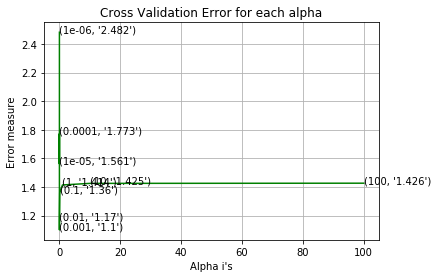

For values of best alpha =  0.001 The train log loss is: 0.4676121735232295
For values of best alpha =  0.001 The cross validation log loss is: 1.0996036226418604
For values of best alpha =  0.001 The test log loss is: 1.1293319215819009


In [36]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='log', random_state=42)
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.3.3 Feature - Respone with BOW

for alpha = 1e-06
Log Loss : 1.8302731648966806
for alpha = 1e-05
Log Loss : 1.8302731648966806
for alpha = 0.0001
Log Loss : 1.8546700364369344
for alpha = 0.001
Log Loss : 1.7822620996431209
for alpha = 0.01
Log Loss : 2.0264443272775634
for alpha = 0.1
Log Loss : 1.808521051561057
for alpha = 1
Log Loss : 1.649499195648993
for alpha = 10
Log Loss : 1.3340771496890087
for alpha = 100
Log Loss : 1.2825381422532185


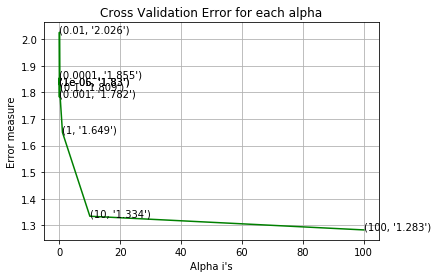

For values of best alpha =  100 The train log loss is: 1.014869525802214
For values of best alpha =  100 The cross validation log loss is: 1.2825381422532185
For values of best alpha =  100 The test log loss is: 1.3237569248761605


In [37]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_bow_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='log', random_state=42)
clf.fit(train_bow_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_response_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.3.4 Feature - Response with TFIDF

for alpha = 1e-06
Log Loss : 1.6007822786828285
for alpha = 1e-05
Log Loss : 1.4700865491813182
for alpha = 0.0001
Log Loss : 1.1298305169483192
for alpha = 0.001
Log Loss : 1.0139589374238192
for alpha = 0.01
Log Loss : 1.1241074023334088
for alpha = 0.1
Log Loss : 1.2927186206129584
for alpha = 1
Log Loss : 1.414950562050182
for alpha = 10
Log Loss : 1.4406786673269387
for alpha = 100
Log Loss : 1.4435569551732812


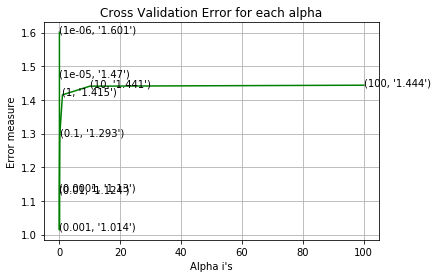

For values of best alpha =  0.001 The train log loss is: 0.7270445520060033
For values of best alpha =  0.001 The cross validation log loss is: 1.0139589374238192
For values of best alpha =  0.001 The test log loss is: 1.0524975290711158


In [38]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_tfidf_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='log', random_state=42)
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0298207114018774
Number of mis-classified points : 0.33270676691729323
-------------------- Confusion matrix --------------------


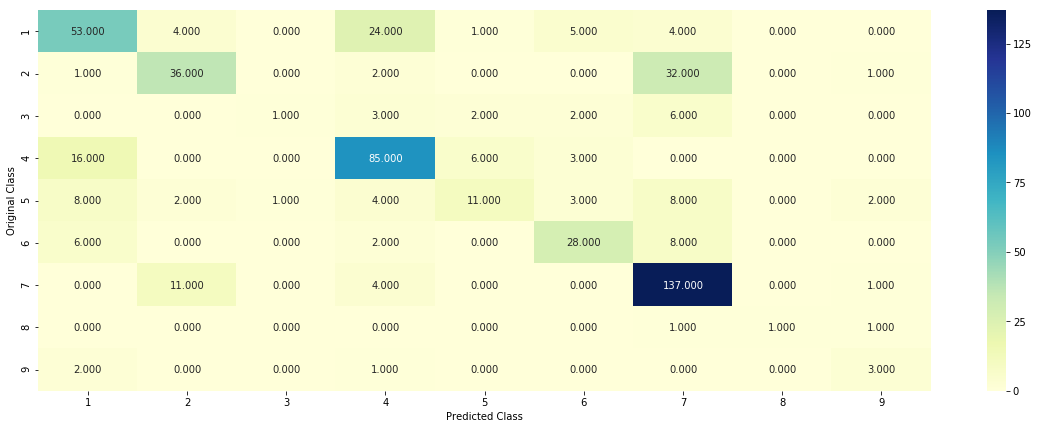

-------------------- Precision matrix (Columm Sum=1) --------------------


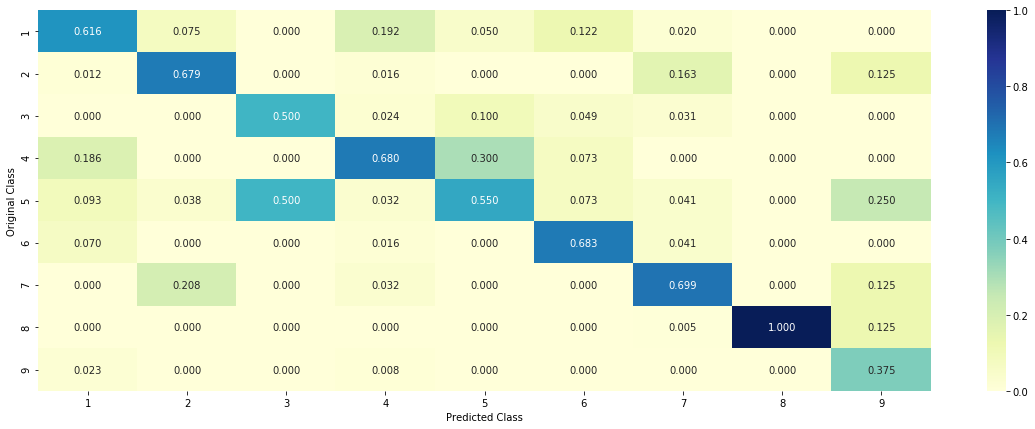

-------------------- Recall matrix (Row sum=1) --------------------


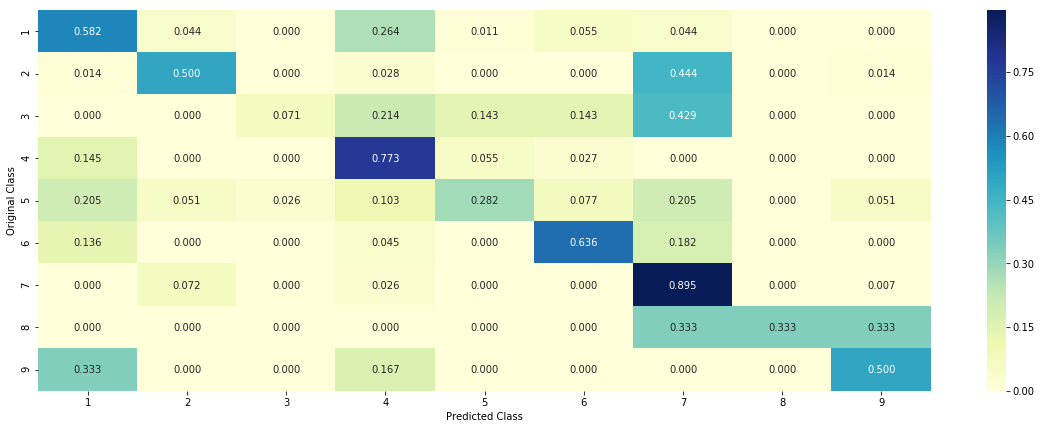

In [39]:
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_tfidf_response_features, train_y, cv_tfidf_response_features, cv_y, clf)

<h4>6.3.4.1. Correctly Classified point</h4>

In [40]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_tfidf_response_features,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(train_tfidf_response_features[test_point_index].todense())
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_tfidf_response_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1161 0.0789 0.0057 0.6647 0.0317 0.0362 0.064  0.0007 0.0019]]
Actual Class : 6
--------------------------------------------------
285 Text feature [several] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h4>6.3.4.2. In-correctly Classified point</h4>

In [41]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_tfidf_response_features,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(train_tfidf_response_features[test_point_index].todense())
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_tfidf_response_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[2.380e-02 7.590e-02 4.600e-03 5.790e-02 6.570e-02 1.183e-01 6.519e-01
  6.000e-04 1.300e-03]]
Actual Class : 6
--------------------------------------------------
412 Text feature [disrupts] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h3>6.4. Linear Support Vector Machines</h3>

#### 6.4.1 Feature - OneHot with BOW

for C = 1e-05
Log Loss : 1.8302731648966806
for C = 0.0001
Log Loss : 1.9397559017672599
for C = 0.001
Log Loss : 2.039294453630545
for C = 0.01
Log Loss : 1.7569326122001026
for C = 0.1
Log Loss : 1.7629881020121687
for C = 1
Log Loss : 1.6755308361593593
for C = 10
Log Loss : 1.4589179903167855
for C = 100
Log Loss : 1.283827703972858
for C = 1000
Log Loss : 1.6205476075813126


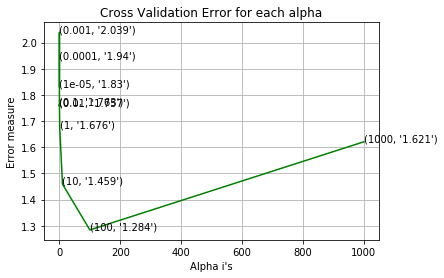

For values of best alpha =  100 The train log loss is: 0.9477136716956934
For values of best alpha =  100 The cross validation log loss is: 1.283827703972858
For values of best alpha =  100 The test log loss is: 1.308775678034629


In [42]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, 
                        penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_bow_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='hinge', random_state=42)
clf.fit(train_bow_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.4.2 Feature - OneHot with TFIDF

for C = 1e-05
Log Loss : 2.037519032495875
for C = 0.0001
Log Loss : 1.48560519027176
for C = 0.001
Log Loss : 1.2172903358192992
for C = 0.01
Log Loss : 1.1212877961703323
for C = 0.1
Log Loss : 1.335757464816945
for C = 1
Log Loss : 1.4267454808673448
for C = 10
Log Loss : 1.426745476789236
for C = 100
Log Loss : 1.426745472635017
for C = 1000
Log Loss : 1.4267454755588407


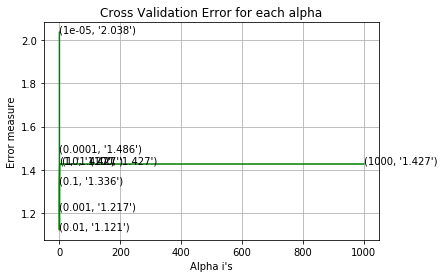

For values of best alpha =  0.01 The train log loss is: 0.6065499481942971
For values of best alpha =  0.01 The cross validation log loss is: 1.1212877961703323
For values of best alpha =  0.01 The test log loss is: 1.2237934559896593


In [43]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, 
                        penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_onehot_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_onehot_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='hinge', random_state=42)
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_onehot_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.4.3 Feature - Response Coding with BOW

for C = 1e-05
Log Loss : 1.8302731648966806
for C = 0.0001
Log Loss : 1.776606782679195
for C = 0.001
Log Loss : 1.8736002210870573
for C = 0.01
Log Loss : 1.8022308121100141
for C = 0.1
Log Loss : 1.7186679784693701
for C = 1
Log Loss : 1.689733624451256
for C = 10
Log Loss : 1.4398716252498935
for C = 100
Log Loss : 1.2903508645726762
for C = 1000
Log Loss : 1.6205327573446544


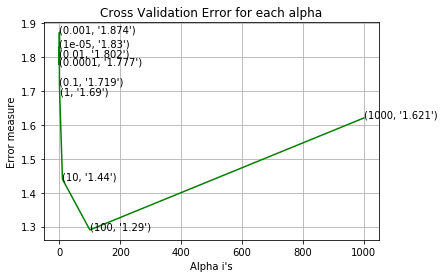

For values of best alpha =  100 The train log loss is: 0.9541811236127639
For values of best alpha =  100 The cross validation log loss is: 1.2903508645726762
For values of best alpha =  100 The test log loss is: 1.3121844483075165


In [44]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, 
                        penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_bow_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_bow_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_bow_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='hinge', random_state=42)
clf.fit(train_bow_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_response_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 6.4.4 Feature - Response Coding with TFIDF

for C = 1e-05
Log Loss : 1.396567456591311
for C = 0.0001
Log Loss : 1.195661407301961
for C = 0.001
Log Loss : 1.1185347722719625
for C = 0.01
Log Loss : 1.137951179988843
for C = 0.1
Log Loss : 1.319939816514339
for C = 1
Log Loss : 1.4440524140821913
for C = 10
Log Loss : 1.4440523162763277
for C = 100
Log Loss : 1.4440523129539573
for C = 1000
Log Loss : 1.4440523593811712


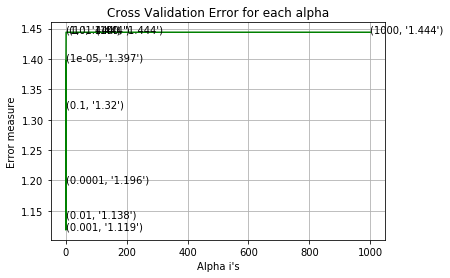

For values of best alpha =  0.001 The train log loss is: 0.5801282028327186
For values of best alpha =  0.001 The cross validation log loss is: 1.1185347722719625
For values of best alpha =  0.001 The test log loss is: 1.1352617082330267


In [45]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, 
                        penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_tfidf_response_features, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(train_tfidf_response_features, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_response_features)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', 
                    alpha=alpha[best_alpha], penalty='l2', 
                    loss='hinge', random_state=42)
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_response_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1514767056832687
Number of mis-classified points : 0.32706766917293234
-------------------- Confusion matrix --------------------


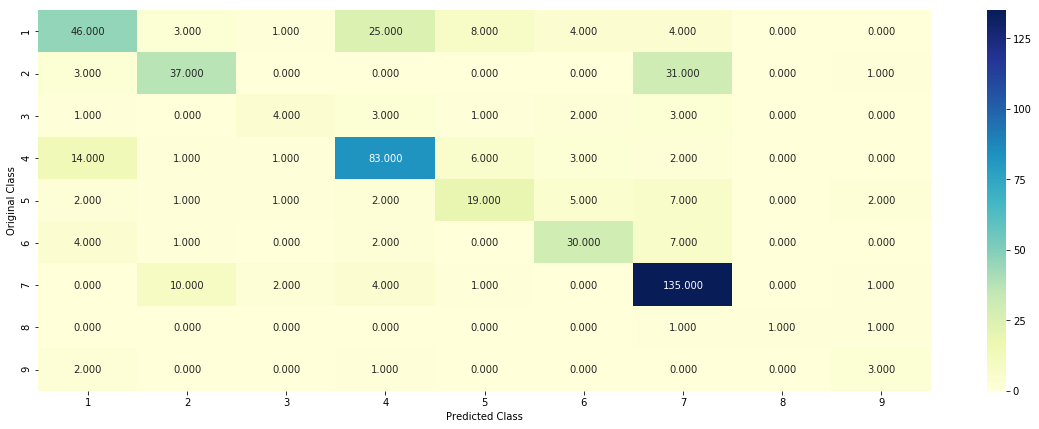

-------------------- Precision matrix (Columm Sum=1) --------------------


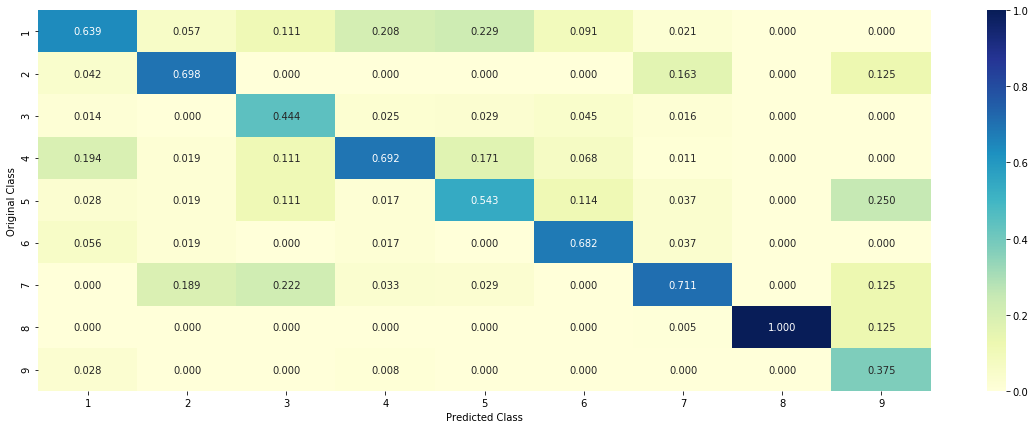

-------------------- Recall matrix (Row sum=1) --------------------


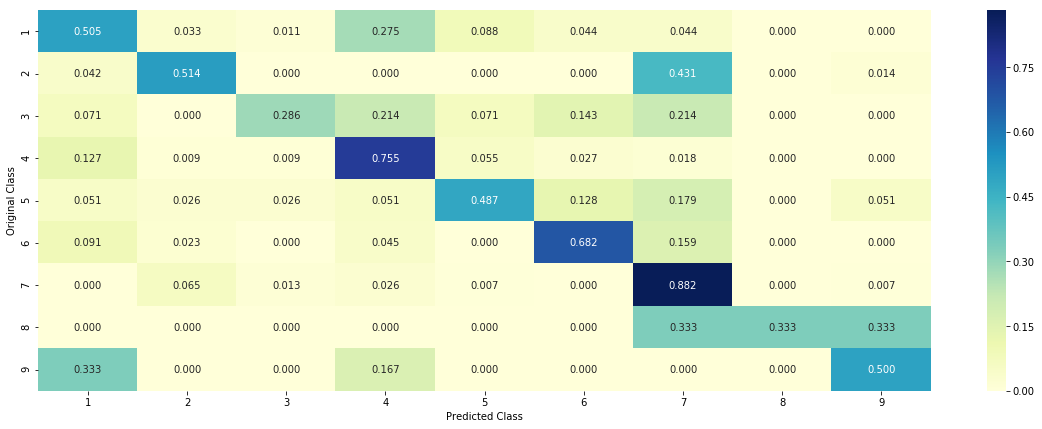

In [46]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_tfidf_response_features, train_y,cv_tfidf_response_features,cv_y, clf)

<h4>Feature Importance</h4>

<h4>6.4.4.1. For Correctly classified point</h4>

In [47]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_tfidf_response_features,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_tfidf_response_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_response_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[5.450e-02 1.200e-02 4.000e-03 4.850e-02 2.370e-02 8.379e-01 1.890e-02
  2.000e-04 2.000e-04]]
Actual Class : 6
--------------------------------------------------
287 Text feature [oophorectomy] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h4>6.4.4.2. For Incorrectly classified point</h4>

In [48]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_tfidf_response_features,train_y)
test_point_index = 100
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_tfidf_response_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_response_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.016e-01 2.800e-02 8.200e-03 7.090e-02 5.670e-02 5.092e-01 2.244e-01
  6.000e-04 4.000e-04]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h3>6.5 Random Forest Classifier</h3>

<h4>6.5.1. Features - OneHot with BOW</h4>

In [49]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_bow_onehot_features, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
        sig_clf.fit(train_bow_onehot_features, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_bow_onehot_features)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], 
                             criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
clf.fit(train_bow_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2124122830515067
for n_estimators = 100 and max depth =  10
Log Loss : 1.1025529609311036
for n_estimators = 200 and max depth =  5
Log Loss : 1.195735411929411
for n_estimators = 200 and max depth =  10
Log Loss : 1.085164982453644
for n_estimators = 500 and max depth =  5
Log Loss : 1.1762609625786704
for n_estimators = 500 and max depth =  10
Log Loss : 1.0783883434104706
for n_estimators = 1000 and max depth =  5
Log Loss : 1.172353894424087
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0793908282291136
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1718554893729816
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0696383055808654
For values of best estimator =  2000 The train log loss is: 0.5985458453387114
For values of best estimator =  2000 The cross validation log loss is: 1.0696383055808654
For values of best estimator =  2000 The test log loss is: 1.0952583634099629


<h4>6.5.2. Features - OneHot with TFIDF</h4>

In [50]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_tfidf_onehot_features, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
        sig_clf.fit(train_tfidf_onehot_features, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf_onehot_features)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], 
                             criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_onehot_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_onehot_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1950933785496447
for n_estimators = 100 and max depth =  10
Log Loss : 1.0744465341090679
for n_estimators = 200 and max depth =  5
Log Loss : 1.1799077918750587
for n_estimators = 200 and max depth =  10
Log Loss : 1.0641194015081716
for n_estimators = 500 and max depth =  5
Log Loss : 1.165457296764393
for n_estimators = 500 and max depth =  10
Log Loss : 1.0454944074002903
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1511568555449312
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0397940509103574
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1452244733653698
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0335219796370754
For values of best estimator =  2000 The train log loss is: 0.5141384993956805
For values of best estimator =  2000 The cross validation log loss is: 1.0335219796370754
For values of best estimator =  2000 The test log loss is: 1.0754312756971138


#### Testing the model with best hyperparameters

Log loss : 1.2240866157581334
Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


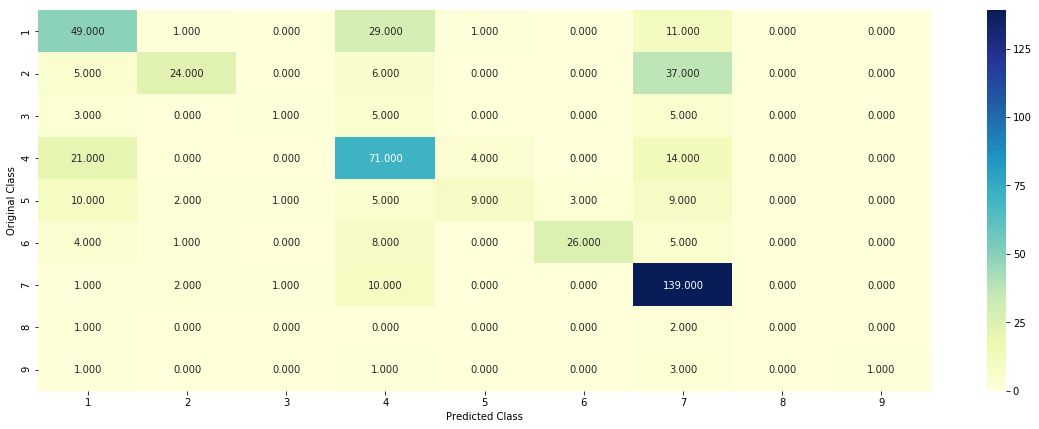

-------------------- Precision matrix (Columm Sum=1) --------------------


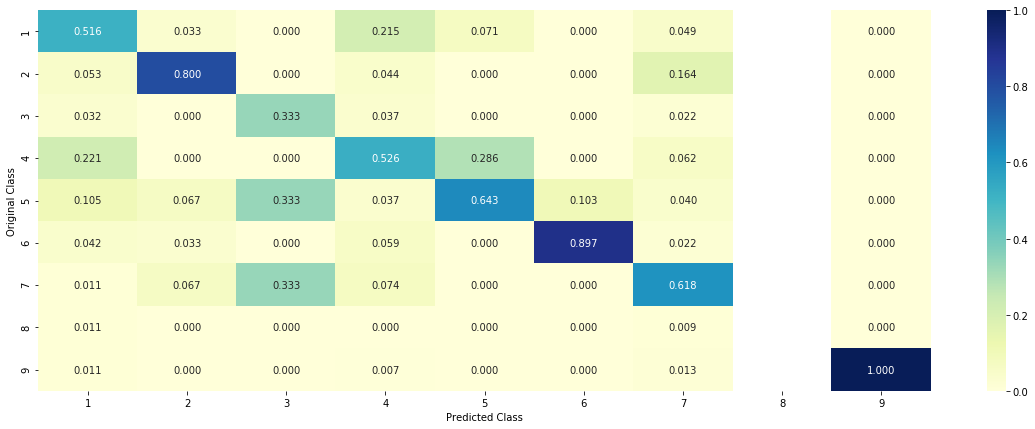

-------------------- Recall matrix (Row sum=1) --------------------


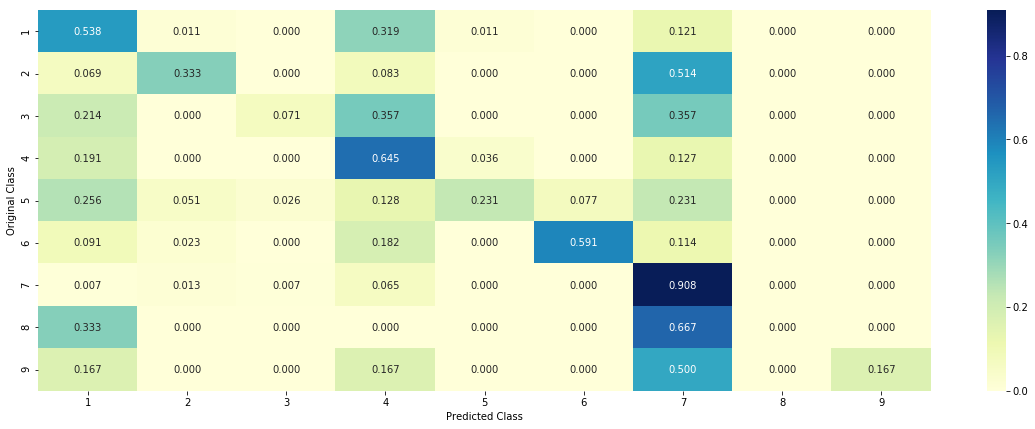

In [56]:
clf = RandomForestClassifier(n_estimators=int(best_alpha), criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_tfidf_onehot_features, train_y, cv_tfidf_onehot_features,cv_y, clf)

<h3>6.5.2.0. Feature Importance</h3>

<h4>6.5.2.1. Correctly Classified point</h4>

In [57]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=int(best_alpha), criterion='gini', max_depth=int(best_alpha%2), random_state=42, n_jobs=-1)
clf.fit(train_tfidf_onehot_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_onehot_features, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(train_tfidf_onehot_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_onehot_features[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[5.690e-02 1.400e-03 1.350e-02 1.760e-02 2.473e-01 6.618e-01 1.500e-03
  0.000e+00 1.000e-04]]
Actual Class : 6
--------------------------------------------------
0 Text feature [transcriptional] present in test data point [True]
5 Text feature [polymorphisms] present in test data point [True]
8 Text feature [myriad] present in test data point [True]
Out of the top  100  features  3 are present in query point


<h4>6.5.2.2. Inorrectly Classified point</h4>

In [59]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_tfidf_onehot_features[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_onehot_features[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1819 0.124  0.0275 0.2609 0.055  0.0551 0.2704 0.0077 0.0174]]
Actuall Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h4>6.5.3. Features - ResponseCoding with BOW</h4>

In [60]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_bow_response_features, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
        sig_clf.fit(train_bow_response_features, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_bow_response_features)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], 
                             criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
clf.fit(train_bow_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_bow_response_features, train_y)

predict_y = sig_clf.predict_proba(train_bow_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_bow_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_bow_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1579080285828156
for n_estimators = 100 and max depth =  10
Log Loss : 1.0783618862339979
for n_estimators = 200 and max depth =  5
Log Loss : 1.1390945624895792
for n_estimators = 200 and max depth =  10
Log Loss : 1.0451797845321633
for n_estimators = 500 and max depth =  5
Log Loss : 1.1237258185812562
for n_estimators = 500 and max depth =  10
Log Loss : 1.0429844618362818
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1215546611533405
for n_estimators = 1000 and max depth =  10
Log Loss : 1.047877847932957
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1151147408835227
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0480891168757336
For values of best estimator =  500 The train log loss is: 0.4592953746110341
For values of best estimator =  500 The cross validation log loss is: 1.0429844618362818
For values of best estimator =  500 The test log loss is: 1.0669229055804925


<h4>6.5.4. Features - ResponseCoding with TFIDF</h4>

In [61]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_tfidf_response_features, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
        sig_clf.fit(train_tfidf_response_features, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf_response_features)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], 
                             criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
clf.fit(train_tfidf_response_features, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(train_tfidf_response_features, train_y)

predict_y = sig_clf.predict_proba(train_tfidf_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf_response_features)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1566838023029447
for n_estimators = 100 and max depth =  10
Log Loss : 1.0491504107179623
for n_estimators = 200 and max depth =  5
Log Loss : 1.1094981656886826
for n_estimators = 200 and max depth =  10
Log Loss : 1.024243704906568
for n_estimators = 500 and max depth =  5
Log Loss : 1.1045251569571664
for n_estimators = 500 and max depth =  10
Log Loss : 1.0231368898913296
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1038931375072731
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0136634349171492
for n_estimators = 2000 and max depth =  5
Log Loss : 1.0956845377742195
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0091289534464267
For values of best estimator =  2000 The train log loss is: 0.36395064846069347
For values of best estimator =  2000 The cross validation log loss is: 1.0091289534464267
For values of best estimator =  2000 The test log loss is: 1.0674155456712104


<h3>6.6 Stack the models </h3>

Stacking up [RandomForest(n_estimators=500, depth=10), LinearSVM(alpha=0.0001), LogisticRegression(alpha=0.001)] as these got least log loss

#### 6.6.1 Features - OneHot with BOW

In [62]:
clf1 = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', criterion='gini', random_state=42, n_jobs=-1)
clf1.fit(train_bow_onehot_features, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_bow_onehot_features, train_y)
print("RandomForest Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_bow_onehot_features))))

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf2.fit(train_bow_onehot_features, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_bow_onehot_features, train_y)
print("Linear SVM Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_bow_onehot_features))))

clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', 
                    loss='log', random_state=42)
clf3.fit(train_bow_onehot_features, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_bow_onehot_features, train_y)
print("Logistic Regression Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_bow_onehot_features))))

alpha = [0.0001,0.001,0.01,0.1,1,10, 100, 1000] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_bow_onehot_features, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_bow_onehot_features))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_bow_onehot_features))
    if best_alpha > log_error:
        best_alpha = log_error

RandomForest Classifier :  Log Loss: 1.24
Linear SVM Classifier :  Log Loss: 1.83
Logistic Regression Classifier :  Log Loss: 1.36
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.182
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.076
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.688
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.237
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.135
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.246
Stacking Classifer : for the value of alpha: 100.000000 Log Loss: 1.348
Stacking Classifer : for the value of alpha: 1000.000000 Log Loss: 1.411


#### 6.6.2 Features - OneHot with TFIDF

In [63]:
clf1 = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', criterion='gini', random_state=42, n_jobs=-1)
clf1.fit(train_tfidf_onehot_features, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_tfidf_onehot_features, train_y)
print("RandomForest Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_tfidf_onehot_features))))

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf2.fit(train_tfidf_onehot_features, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_tfidf_onehot_features, train_y)
print("Linear SVM Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_tfidf_onehot_features))))

clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', 
                    loss='log', random_state=42)
clf3.fit(train_tfidf_onehot_features, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_tfidf_onehot_features, train_y)
print("Logistic Regression Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_tfidf_onehot_features))))

alpha = [0.0001,0.001,0.01,0.1,1,10, 100, 1000] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_tfidf_onehot_features, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_tfidf_onehot_features))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_tfidf_onehot_features))
    if best_alpha > log_error:
        best_alpha = log_error

RandomForest Classifier :  Log Loss: 1.18
Linear SVM Classifier :  Log Loss: 1.05
Logistic Regression Classifier :  Log Loss: 1.02
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.175
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.010
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.426
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.020
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.111
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.477
Stacking Classifer : for the value of alpha: 100.000000 Log Loss: 2.023
Stacking Classifer : for the value of alpha: 1000.000000 Log Loss: 2.732


#### 6.6.3 Features - Response with BOW

In [64]:
clf1 = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', criterion='gini', random_state=42, n_jobs=-1)
clf1.fit(train_bow_response_features, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_bow_response_features, train_y)
print("RandomForest Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_bow_response_features))))

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf2.fit(train_bow_response_features, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_bow_response_features, train_y)
print("Linear SVM Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_bow_response_features))))

clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', 
                    loss='log', random_state=42)
clf3.fit(train_bow_response_features, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_bow_response_features, train_y)
print("Logistic Regression Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_bow_response_features))))

alpha = [0.0001,0.001,0.01,0.1,1,10, 100, 1000] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_bow_response_features, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_bow_response_features))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_bow_response_features))
    if best_alpha > log_error:
        best_alpha = log_error

RandomForest Classifier :  Log Loss: 1.10
Linear SVM Classifier :  Log Loss: 1.83
Logistic Regression Classifier :  Log Loss: 1.34
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.180
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.053
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.582
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.126
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.088
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.288
Stacking Classifer : for the value of alpha: 100.000000 Log Loss: 1.565
Stacking Classifer : for the value of alpha: 1000.000000 Log Loss: 1.777


#### 6.6.4 Features - Response with TFIDF

In [65]:
clf1 = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', criterion='gini', random_state=42, n_jobs=-1)
clf1.fit(train_tfidf_response_features, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_tfidf_response_features, train_y)
print("RandomForest Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_tfidf_response_features))))

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf2.fit(train_tfidf_response_features, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_tfidf_response_features, train_y)
print("Linear SVM Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_tfidf_response_features))))

clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', 
                    loss='log', random_state=42)
clf3.fit(train_tfidf_response_features, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_tfidf_response_features, train_y)
print("Logistic Regression Classifier :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_tfidf_response_features))))

alpha = [0.0001,0.001,0.01,0.1,1,10, 100, 1000]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_tfidf_onehot_features, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_tfidf_onehot_features))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_tfidf_onehot_features))
    if best_alpha > log_error:
        best_alpha = log_error

RandomForest Classifier :  Log Loss: 1.04
Linear SVM Classifier :  Log Loss: 1.09
Logistic Regression Classifier :  Log Loss: 1.03
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.175
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.010
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.426
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.020
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.111
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.477
Stacking Classifer : for the value of alpha: 100.000000 Log Loss: 2.023
Stacking Classifer : for the value of alpha: 1000.000000 Log Loss: 2.732


<h4>6.6.4.1 Testing the model with the best hyper parameters</h4>

Log loss (train) on the stacking classifier : 0.4094484719965551
Log loss (CV) on the stacking classifier : 1.0199758344670404
Log loss (test) on the stacking classifier : 1.0615019072459961
Number of missclassified point : 0.3458646616541353
-------------------- Confusion matrix --------------------


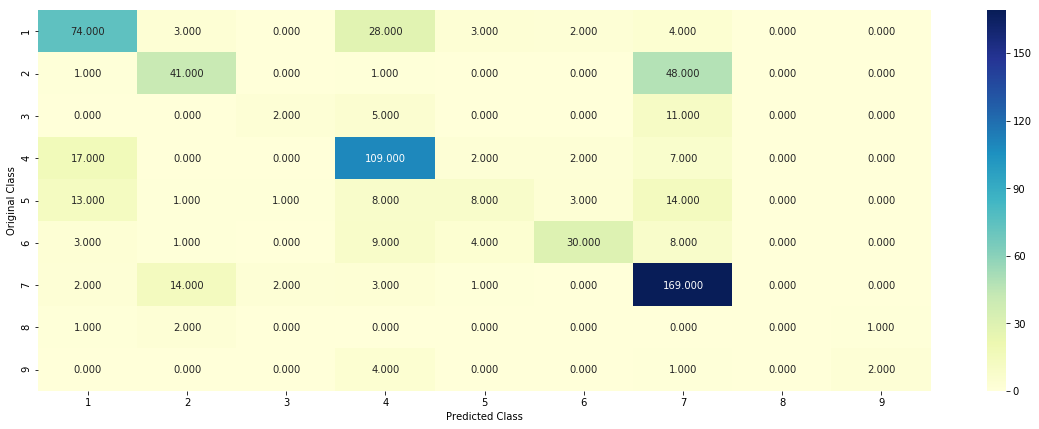

-------------------- Precision matrix (Columm Sum=1) --------------------


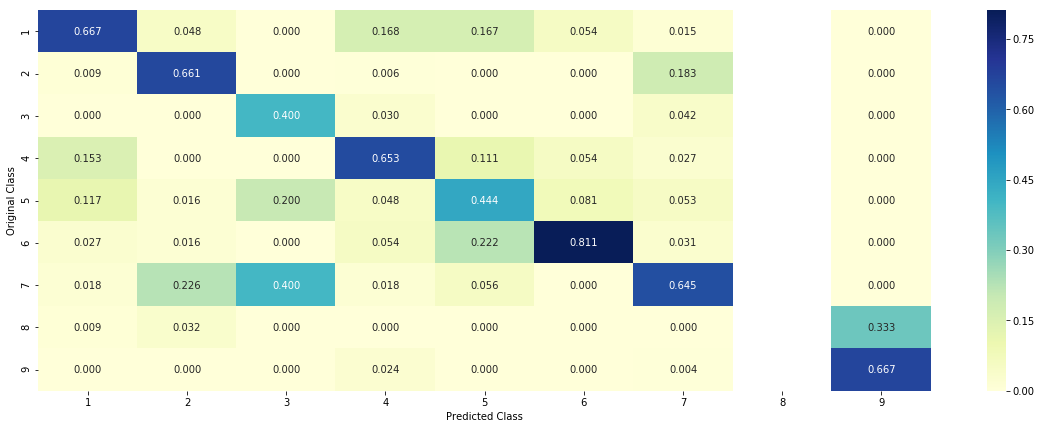

-------------------- Recall matrix (Row sum=1) --------------------


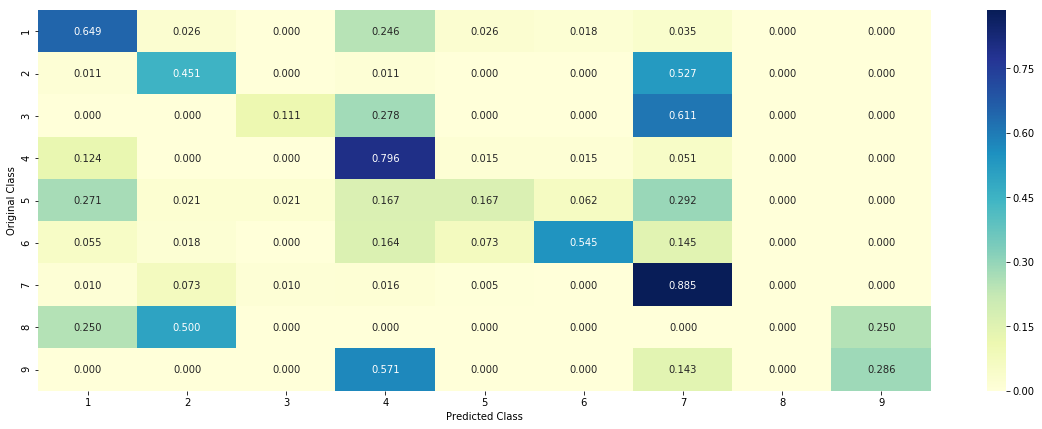

In [66]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_tfidf_onehot_features, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_tfidf_onehot_features))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_tfidf_onehot_features))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_tfidf_onehot_features))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_tfidf_onehot_features)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_tfidf_onehot_features))

### 6.7. Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.5828435172445474
Log loss (CV) on the VotingClassifier : 1.0347273959826861
Log loss (test) on the VotingClassifier : 1.0550490439340257
Number of missclassified point : 0.33533834586466166
-------------------- Confusion matrix --------------------


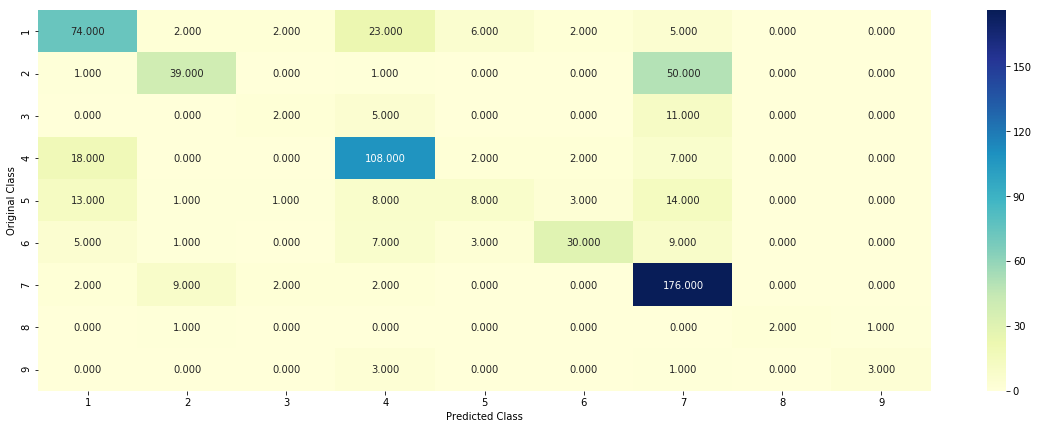

-------------------- Precision matrix (Columm Sum=1) --------------------


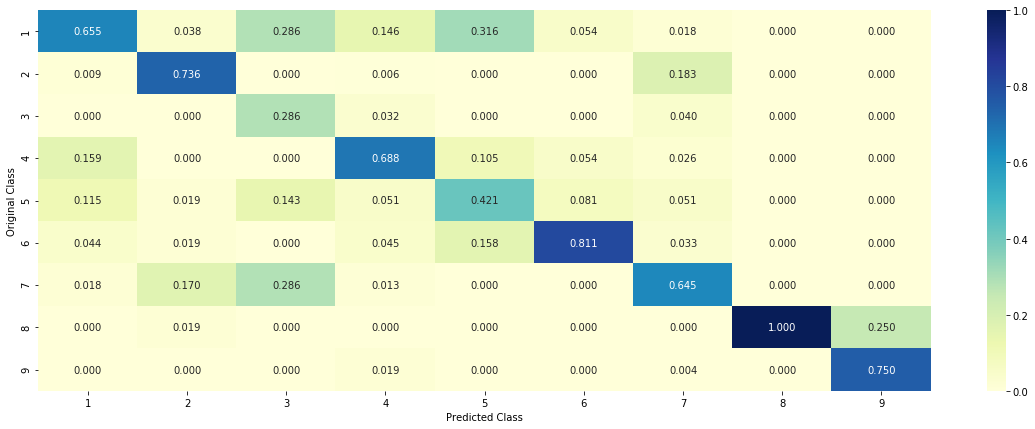

-------------------- Recall matrix (Row sum=1) --------------------


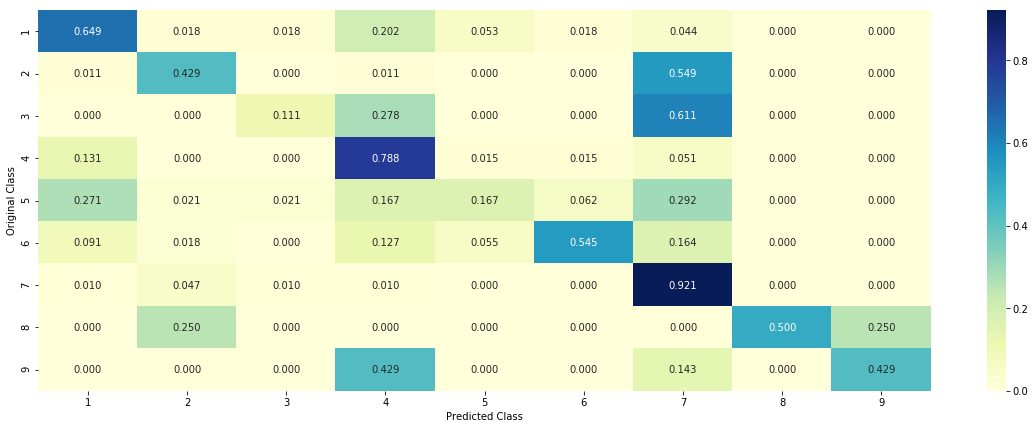

In [67]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('rf', sig_clf1), ('lin', sig_clf2), ('logistic', sig_clf3)], voting='soft')
vclf.fit(train_tfidf_onehot_features, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_tfidf_onehot_features)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_tfidf_onehot_features)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_tfidf_onehot_features)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_tfidf_onehot_features)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_tfidf_onehot_features))

## 7. Results

In [69]:
from prettytable import PrettyTable

print("Here I am only displaying the best result of each model that I tried with the featurization that gave the minimal log loss")
x = PrettyTable()
x.field_names = ["Featurization", "Model", "Train log loss", "Test log loss", "CV log loss"]

prettytable_data = [
    ["gene(Onehot)+variantion(Onehot)+Text(TFIDF)", "MultinomialNB(alpha: 10)", 1.019, 1.261, 1.1927],
    ["gene(Response)+variantion(Response)+Text(TFIDF)","KNeighborsClassifier(n_neighbors=15)", 0.944, 1.221, 1.144],
    ["gene(Response)+variantion(Response)+Text(TFIDF)","LogisticRegression(alpha=0.001)", 0.727, 1.053, 1.014],
    ["gene(Response)+variantion(Response)+Text(TFIDF)","SupportVectorMachines(alpha=0.001)", 0.580, 1.135, 1.118],
    ["gene(Onehot)+variantion(Onehot)+Text(TFIDF)","RandomForest(n_estimator=2000, max_depth=10)", 0.514, 1.075, 1.033],
    ["gene(Onehot)+variantion(Onehot)+Text(TFIDF)","RandomForest(n_estimator=2000, max_depth=10)", 0.514, 1.075, 1.033],
    ["gene(Onehot)+variantion(Onehot)+Text(TFIDF)","MaxVoteClf(RandomForest, LinearReg, LogisticReg)", 0.583, 1.055, 1.035]
]
[x.add_row(i) for i in prettytable_data]
print(x)

Here I am only displaying the best result of each model that I tried with the featurization that gave the minimal log loss
+-------------------------------------------------+--------------------------------------------------+----------------+---------------+-------------+
|                  Featurization                  |                      Model                       | Train log loss | Test log loss | CV log loss |
+-------------------------------------------------+--------------------------------------------------+----------------+---------------+-------------+
|   gene(Onehot)+variantion(Onehot)+Text(TFIDF)   |             MultinomialNB(alpha: 10)             |     1.019      |     1.261     |    1.1927   |
| gene(Response)+variantion(Response)+Text(TFIDF) |       KNeighborsClassifier(n_neighbors=15)       |     0.944      |     1.221     |    1.144    |
| gene(Response)+variantion(Response)+Text(TFIDF) |         LogisticRegression(alpha=0.001)          |     0.727      |     1.0